## Correlations
The data used in this notebook is lymphocyte data for two patients' B cells and T cells. Here we calculate Spearman correlation coefficients to compare the level of change in one month. As context, we compare that level of change to the level of change between B and T cells.

First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_FragPipe(version="July_noMBR_FP", contains=[])

In [2]:
new_names={}
for c in data_raw.columns.values: 
    new_names[c] = c.split(' ')[0]
data_raw.rename(columns=new_names, inplace=True)
data_raw.head()

,Blank_3,Blank_4,Blank_5,Subject1_B_cells_062920_C_10,Subject1_B_cells_062920_C_11,Subject1_B_cells_062920_C_12,Subject1_B_cells_062920_C_13,Subject1_B_cells_062920_C_9,Subject1_B_cells_072920_C_4,Subject1_B_cells_072920_C_5,...,Subject2_T_cells_062920_F_12,Subject2_T_cells_062920_F_13,Subject2_T_cells_062920_F_14,Subject2_T_cells_062920_F_9,Subject2_T_cells_072920_F_1,Subject2_T_cells_072920_F_3,Subject2_T_cells_072920_F_4,Subject2_T_cells_072920_F_5,Subject2_T_cells_072920_F_6,Subject2_T_cells_072920_F_8
Protein ID,,,,,,,,,,,,,,,,,,,,,
A0A0B4J2D5,0.0,0.0,0.0,3203277.5,4697996.0,7346776.5,8472867.0,4280919.5,0.0,4787781.50,...,0.0,4905873.00,0.0,3405266.0,4656720.00,1673629.9,6060600.5,2407679.5,7791855.0,5542659.50
A0AVT1,0.0,0.0,0.0,1917388.2,3033529.2,3773018.8,1865758.6,5191332.5,3332031.5,2464089.00,...,1091121.4,630647.25,576871.9,0.0,0.00,0.0,0.0,827356.1,1260652.0,0.00
A0FGR8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,1514363.4,866311.94,0.0,0.0,0.00,0.0,0.0,0.0,653698.6,879074.56
A6NHR9,0.0,0.0,0.0,2650513.5,0.0,3788095.8,0.0,0.0,1845555.5,933499.44,...,0.0,0.00,0.0,0.0,430484.97,0.0,0.0,0.0,538303.6,948190.40
A8K2U0,0.0,0.0,0.0,0.0,0.0,0.0,1149867.8,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00


In [3]:
import numpy as np
from numpy import nan, log2
from statistics import median

data_log2 = log2(data_raw.replace(0,nan))

Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [4]:
import data_utils    
sets=['_B_cells','_T_cells',
      'Subject1','Subject2','062920','072920',"_"]
cell_types = ['_B', '_T']
indecies = data_log2.apply(data_utils.check_n_of_each_type, axis=1,
                      cell_types = cell_types)
data_filtered = data_log2[indecies]
#data.head()

Now we normalize across runs.

In [5]:
data = data_filtered.apply(lambda series: series-median(series.dropna()))

In [6]:
from scipy.stats import variation
from statistics import mean
import pandas as pd
from numpy import isnan
import matplotlib.pyplot as plt
import seaborn as sns

### Correlation coefficient
Next, we show reproducibility of the replicates by Spearman correlation coefficient.

In [7]:
try: 
    data.drop(columns=['Blank_5','Blank_4','Blank_3'], inplace=True)
except: print()

In [8]:
correlations = data.corr(method="spearman")

#drop self-correlations of 1
for sample in correlations.columns:
    correlations[sample][sample]=nan

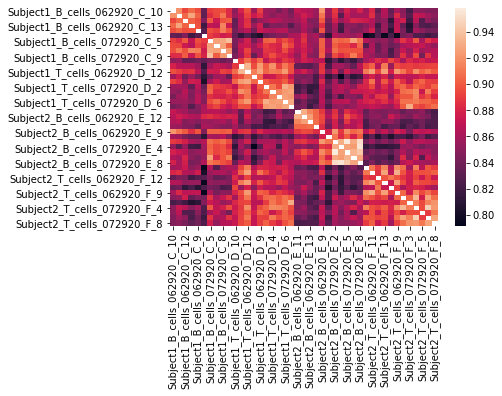

In [9]:
sns.heatmap(correlations)

Now, I could simply plot all possible correlation combinations. This is too busy to be intuitive to read. I can collapse the heatmap by showing each comparison as the average across technical replicates, i.e., Subject 1's B cells from June against Subject 1's B cells from July is on average a correlation of .88

In [10]:
all_cell_types = ["Subject1_B_cells_062920","Subject1_B_cells_072920", "Subject2_B_cells_062920",  "Subject2_B_cells_072920",
              "Subject1_T_cells_062920","Subject1_T_cells_072920","Subject2_T_cells_062920", "Subject2_T_cells_072920"]

corr_summary = {}
for i in all_cell_types:
    corr_summary[i] = {}
    for j in all_cell_types:
        subset = list(s for s in correlations.columns if i in s)
        subset2 = list(s for s in correlations.columns if j in s)

        d = correlations[subset].loc[subset2]
        means = d.apply(lambda r: mean(r.dropna()))
        m = mean(means)
        corr_summary[i][j] = m
    
corr_summary = pd.DataFrame(corr_summary)


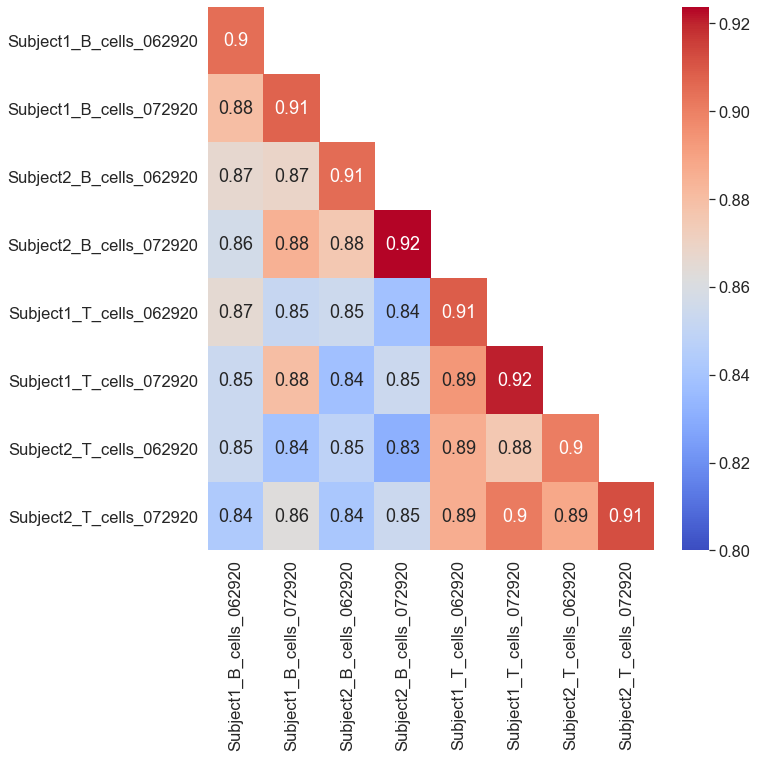

In [11]:
sns.set(font_scale=1.5)
sns.set_style("white")


fig = plt.figure(figsize=(10,10))
mask = np.zeros(corr_summary.shape, dtype=bool)

mask[np.triu_indices(len(mask))] = True

for i in range(0,len(mask)):
    mask[i][i]=False
        
sns.heatmap(corr_summary, cmap = 'coolwarm', mask = mask, annot=True, vmin=0.80)

#plt.savefig("data/correlations.png", dpi=300, bbox_inches='tight')

This heatmap is a little more helpful. Technical reproducibility is very high. T cells are pretty high. Comparing B cells to T cells has the lowest correlations. Our primary interest, however, is in identifying the time dependent change and contextualizing it against B-T differences. This message is not clear from the heatmap, so I instead plot the comparisions of interest as a box plot.

#### Figure 3: Is time dependant change a lot?
First, I want the technical reproducibility. I'll use B cells and June, the first month's, data. I'll use both subjects, but only compare replicates within a subject to exclude inter-subject variability. 

In [12]:
B_June_technical = []
for cell_type in ["Subject1_B_cells_062920", "Subject2_B_cells_062920"]:
    
    blocks_of_type = list(s for s in correlations.keys() if cell_type in s)
    
    corr_by_type = correlations[blocks_of_type]
    corr_by_type = corr_by_type.loc[blocks_of_type]
    
    #remove duplicate corner and self-correlations of 1
    corr_by_type =corr_by_type.mask(np.tril(np.ones(corr_by_type.shape)).astype(np.bool))
        
    for i in corr_by_type.values.flatten():
        if not isnan(i):
            B_June_technical.append(i)
            
mean(B_June_technical)

0.9049602577683578

Second, I want to show the time dependent change. I'll do the same as getting the technical variability, but rather than June against June, get June against July.

In [13]:
B_time = []
for cell_type in ["Subject1_B_cells", "Subject2_B_cells"]:
    
    time_1_type = list(s for s in correlations.keys() if "{0}_062920".format(cell_type) in s)
    time_2_type = list(s for s in correlations.keys() if "{0}_072920".format(cell_type) in s)
    
    corr_by_type = correlations[time_1_type]
    corr_by_type = corr_by_type.loc[time_2_type]
    
    #remove duplicate corner and self-correlations of 1
    corr_by_type =corr_by_type.mask(np.tril(np.ones(corr_by_type.shape)).astype(np.bool))
        
    for i in corr_by_type.values.flatten():
        if not isnan(i):
            B_time.append(i)
            
mean(B_time)

0.8715046395857332

Third, I want to show B versus T differences. This provides context for the time dependent change. I'll just use data from the first month in this figure, but the results are similar for both.

In [14]:
B_T = []
for cell_type in ["Subject1", "Subject2"]:
    
    B_type = list(s for s in correlations.keys() if "{0}_B_cells_062920".format(cell_type) in s)
    T_type = list(s for s in correlations.keys() if "{0}_T_cells_062920".format(cell_type) in s)
    
    corr_by_type = correlations[B_type]
    corr_by_type = corr_by_type.loc[T_type]
    
    #remove duplicate corner and self-correlations of 1
    corr_by_type =corr_by_type.mask(np.tril(np.ones(corr_by_type.shape)).astype(np.bool))
        
    for i in corr_by_type.values.flatten():
        if not isnan(i):
            B_T.append(i)
            
mean(B_T)

0.8522009784078516

Now, I have variability for each of my three comparisons. I plot these as a boxplot. To make it easier, I'll combine the lists in a DataFrame.

In [21]:
selected_comparisons = pd.DataFrame({'B cells - Day 0':B_June_technical,
                        'B cells - Day 0 vs 30':B_time,
                        "B vs T cells - Day 0":B_T,
                       })

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

B cells - Day 0 v.s. B cells - Day 0 vs 30: t-test independent samples with Bonferroni correction, P_val=1.950e-04 stat=4.487e+00
B cells - Day 0 vs 30 v.s. B vs T cells - Day 0: t-test independent samples with Bonferroni correction, P_val=6.272e-02 stat=2.410e+00
B cells - Day 0 v.s. B vs T cells - Day 0: t-test independent samples with Bonferroni correction, P_val=4.074e-12 stat=1.033e+01


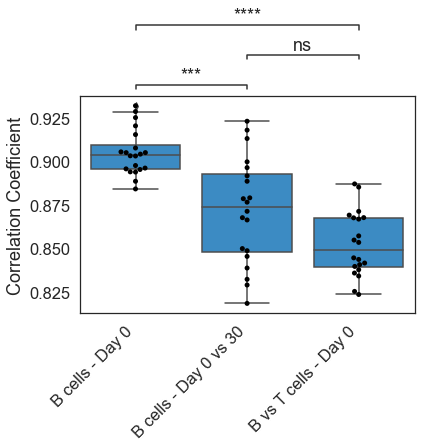

In [22]:

from statannot import add_stat_annotation

fig = plt.figure()
ax = sns.boxplot(data=selected_comparisons, color='#258fda')
ax = sns.swarmplot(data=selected_comparisons, color="black")

add_stat_annotation(ax, data=selected_comparisons,
                    box_pairs=[('B cells - Day 0', 'B cells - Day 0 vs 30'), ('B cells - Day 0', "B vs T cells - Day 0"), 
                               ('B cells - Day 0 vs 30', "B vs T cells - Day 0")],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)

ax.set(ylabel="Correlation Coefficient")

plt.xticks(rotation=45, ha='right')
plt.savefig("data/figure3_selected_correlations.png", dpi=300, bbox_inches='tight')

To confirm that these are statistically significant difference, I use a T test. Note that statistically significant can refer to a small change and merely state that there is a change. This is statistically significant, but further investigation is required to say if the magnitude of change (2%) is biologically meaningful.

#### Other key comparisons
I want to report the technical variability. As you can see from the summary heatmap, this should be around 0.91. This averages by cell type.

In [17]:
technical_corr = {}
for i in corr_summary:
     technical_corr[i] = corr_summary[i][i]

B = []
T = []
for i in technical_corr:
    if "B_cells" in i:
        B.append(technical_corr[i])
    if "T_cells" in i:
        T.append(technical_corr[i])
print( "Technical variability of B cells: ",mean(B))
print("Technical variability of T cells: ", mean(T))
mean(technical_corr.values())

Technical variability of B cells:  0.9103257563701247
Technical variability of T cells:  0.910753365720103


0.9105395610451139

Here we split the correlation data by cell type to compare inter-cell type variability.

In [18]:
corr_type = {}
for cell_type in ["B_cells","T_cells"]:
    
    blocks_of_type = list(s for s in corr_summary.keys() if cell_type in s)
    
    corr_by_type = corr_summary[blocks_of_type]
    corr_by_type = corr_by_type.loc[blocks_of_type]
    
    #drop technical replicates
    for sample in corr_by_type.columns:
        corr_by_type[sample][sample]=nan
        
    #display(corr_by_type)
    
    corr_type[cell_type] = corr_by_type
    
    #take the average of the correlations between a sample and  
    #    the other samples of the same type
    summary = corr_by_type.apply(lambda x: mean(x.dropna()))
    
    print (cell_type,"average correlation:\t",mean(summary))
    

B_cells average correlation:	 0.8721728723434803
T_cells average correlation:	 0.888584050579865


In [19]:
B_type = list(s for s in corr_summary.keys() if "B_cells" in s)
T_type = list(s for s in corr_summary.keys() if "T_cells" in s)
    
corr_by_type = corr_summary.loc[B_type, T_type]
    
corr_type[cell_type] = corr_by_type
    
#take the average of the correlations between a sample and  
#    the other samples of the same type
summary = corr_by_type.apply(lambda x: mean(x.dropna()))
    
print ("Average Cross-type correlation:\t",mean(summary))

Average Cross-type correlation:	 0.8505750792909113


In [20]:
B_type = list(s for s in corr_summary.keys() if "B_cells_062920" in s)
T_type = list(s for s in corr_summary.keys() if "B_cells_072920" in s)
    
corr_by_type = corr_summary.loc[B_type, T_type]
    
corr_type[cell_type] = corr_by_type
    
#take the average of the correlations between a sample and  
#    the other samples of the same type
summary = corr_by_type.apply(lambda x: mean(x.dropna()))
    
print ("Average Cross-time correlation:\t",mean(summary))

Average Cross-time correlation:	 0.8704404405318026
